# Machine Learning Implementation

## Imports

In [345]:
import itertools
import json
import logging

import graphviz
import numpy as np
import pandas as pd
import plotly.offline as py
from graphviz import Digraph
from IPython.display import display
from plotly import graph_objects as go
from scipy.special import logsumexp, expit
from sklearn.datasets import load_boston, load_iris
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

## Neural network

### The maths

A neural network mimics the brain as a series of nodes structured in layers. The network passes information between the layers depending on the layer's weights and the outputs from the previous layer.

Let's assume we have data $x_1, x_2, \dots x_m \in \mathbb{R}^{(n^0,1)}$ where m is the number of training examples and $n^0$ is the number of features in $x_i$
Let's assume a classification problem with $y_1, y_2, \dots y_m \in{0,1}$

Define $X$ with shape $(m, n^0)$ by stacking $x_1, x_2, \dots x_m$ as
$$
X = \begin{pmatrix}
- & x_1^T & -\\
- & x_2^T & -\\
&\vdots& \\
- & x_m^T & -
\end{pmatrix}	
$$

We define the network with $L$ layers where the $L$'th layer is the output layer and layer $0$ is the input layer. The layers $1, 2, \dots, L-1$ are known as the hidden layers. We define $n^l$ to be the number of nodes in layer $l$ for $l \in 0, 1, \dots, L$.

#### Feed forwards

For a fully connected network the input to a node is equal to the sum of the output from each of the nodes in the previous layer multiplied by the weights for that layer plus a bias.  
The output of the node is calculated by transforming the input using the activation function $g$. Various activation functions can be used but often it is chosen to be the sigmoid function, the relu function or the tanh function.

For node $i$ in layer $l$ where $i\in 1,\dots n^l$ we define the net input $z^l_i$ and output $a^l_i$ as follows

$$
\begin{align}
z^l_i&=\sum^{n^{l-1}}_{j=0}W^l_{ij}a^{l-1}_j + \beta^l_i \quad i\in 1,\dots, n^l\quad(1)\\
a^l_i&=g(z^l_i) \quad i\in 1,\dots, n^l\quad(2)\\
\end{align}
$$

Note weight $W_{ij}^l$ goes from $a_j^{l-1} \to z_i^{l}$

Let's assume that the activation function $g$ is the sigmoid function then 

$$
\begin{align}
g(x)&=\frac{1}{1+e^{-x}}\quad(3)\\
g'(x)&=g(x)(1-g(x))\quad(4)
\end{align}
$$

Feed forward as vectors

$$
\begin{align}
z^l &= W^l*a^{l-1} + \beta^l\quad(5)\\
a^l &= g(z^l)\quad(6)\\
\end{align}\\
\quad z^l,\beta^l\in \mathbb{R}^{(n^l, 1)}
\quad a^{l-1}\in \mathbb{R}^{(n^{l-1}, 1)}
\quad W^{l-1} \in \mathbb{R}^{(n^{l}, n^{l-1})}
$$

Feed forward as matrices! Performing on multiple samples $x_i$ at the same time

$$
\begin{align}
Z^l &= W^l*A^{l-1} + B^l\quad(7)\\
A^l &= g(Z^l)\quad(8)\\
Z^1 &= W^1*X^{T} + B^l\quad(9)\\
\end{align}\\
\quad Z^l, B^l\in \mathbb{R}^{(n^l, m)}
\quad a^{l-1}\in \mathbb{R}^{(n^{l-1}, m)}
\quad W^{l-1} \in \mathbb{R}^{(n^{l}, n^{l-1})}
$$

Note the columns of $Z^l$ and $A^l$ relate to $z^l$ and $a^l$  for the individual samples $x_k \quad k\in 1\dots m$

$$
Z^l = \begin{pmatrix}
| & | & \dots & |\\
z^l_{x_1} & z^l_{x_2} & \dots & z^l_{x_m}\\
| & | & \dots & |
\end{pmatrix}
\quad
A^l = \begin{pmatrix}
| & | & \dots & |\\
a^l_{x_1} & a^l_{x_2} & \dots & a^l_{x_m}\\
| & | & \dots & |
\end{pmatrix}	
$$

The m columns of $B^l$ are all copies of $\beta^l$

$$
B^l = \begin{pmatrix}
| & | & \dots & |\\
\beta^l & \beta^l & \dots & \beta^l\\
| & | & \dots & |
\end{pmatrix}	
$$

#### Back propagation

In the binary classification context we can define the loss a.k.a cost function as the cross entropy (for one input data item $x_i$ and true output $y_i$ where $a^L_1$ is the model prediction of $y_i$ being in class 1 or $P(y\in C_1)$ the loss is defined as follows:  

$$
\mathcal{L} = y_i\log(a^L_1)+(1-y_i)\log(1-a^L_{1})\quad(10)
$$

Note this is just the loss for one given sample $x_i$

As in all the other algorithms we seek to improve the model by changing the weights to reduce the loss. We do this by stepping the weights in the direction of the negative gradient of the cost function.

$$
\begin{align}
W^l_{ij} &\to W^l_{ij} + \eta \frac{\partial \mathcal{L}}{\partial W^l_{ij}} 
\quad i\in 1,\dots, n^l
\quad j\in 1,\dots, n^{l-1}
\quad l\in 1,\dots, L \quad(11)\\
\beta^l_{i} &\to \beta^l_{i} + \eta \frac{\partial \mathcal{L}}{\partial \beta^l_{i}} 
\quad i\in 1,\dots, n^l
\quad l\in 1,\dots, L\quad(12)
\end{align}
$$

Back propagation is involved but ultimately comes down to calculating $\frac{\partial \mathcal{L}}{\partial W^l_{ij}} $ and $\frac{\partial \mathcal{L}}{\partial \beta^l_{i}}$.  
As the name back propagation implies we calculate the derivatives starting at the end or the "right" of the network and propagate the error backwards (using the chain rule).

Above we have defined the loss for one training example. In this way we can updated the weights in a stochastic manner - or we can average the error across multiple samples and used batch gradient descent or just regular gradient descent if we average across all samples.

**Calculating $\frac{\partial \mathcal{L}}{\partial W^l_{ij}} $ and $\frac{\partial \mathcal{L}}{\partial \beta^l_{i}}$**

Note for each layer $l$

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial W^l_{ij}} &= 
\frac{\partial \mathcal{L}}{\partial z^l_{i}}
\frac{\partial z^l_{i}}{\partial W^l_{ij}}
, \quad
\frac{\partial \mathcal{L}}{\partial \beta^l_{i}} = 
\frac{\partial \mathcal{L}}{\partial z^l_{i}}
\frac{\partial z^l_{i}}{\partial \beta^l_{i}}\quad(13)
\end{align}
$$

or defining $\delta^l_i=\frac{\partial \mathcal{L}}{\partial z^l_{i}}$

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial W^l_{ij}} &= 
\delta^l_i
\frac{\partial z^l_{i}}{\partial W^l_{ij}}
, \quad
\frac{\partial \mathcal{L}}{\partial \beta^l_{i}} = 
\delta^l_i
\frac{\partial z^l_{i}}{\partial \beta^l_{i}}\quad(14)
\end{align}
$$

We know ( by differentiating equation (1))

$$
\frac{\partial z^l_{i}}{\partial W^l_{ij}} = a^{l-1}_j
,\quad
\frac{\partial z^l_{i}}{\partial \beta^l_{i}} = 1
\quad(15)
$$

So in order to calculate the derivatives we must calculate $\delta^l_i$

For the very last layer (when there is only one node in the output layer) we can use the chain rule to write

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial W^L_{1j}} &= 
\frac{\partial \mathcal{L}}{\partial z^L_{1}}
\frac{\partial z^L_{1}}{\partial W^L_{1j}} = 
\delta^L_i
\frac{\partial z^L_{1}}{\partial W^L_{1j}}\quad(16)\\
\frac{\partial \mathcal{L}}{\partial W^L_{1j}} &= 
\frac{\partial \mathcal{L}}{\partial a^L_{1}}
\frac{\partial a^L_{1}}{\partial z^L_{1}}
\frac{\partial z^L_{1}}{\partial W^L_{1j}}\quad(17)\\
\end{align}
$$

Note

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial a^L_{1}} &= 
\frac{\partial}{\partial a^L_{1}}\left(
y_i\log(a^L_1)+(1-y_i)\log(1-a^L_{1})
\right)\quad(18)\\
\frac{\partial \mathcal{L}}{\partial a^L_{1}} &= 
\frac{y_i}{a^L_1} + \frac{1-y_i}{1-a^L_1}\quad(19)
\end{align}
$$

Assuming sigmoid activation

$$
\begin{align}
\frac{\partial a^L_{i}}{\partial z^L_{i}} &=
\frac{\partial}{\partial z^L_{i}}\left(
g(z^L_{i})
\right) = 
\frac{\partial}{\partial z^L_{i}}\left(
\sigma(z^L_{i})
\right)\\
&= \sigma'(z^L_{i})\\
&= \sigma(z^L_{i})(1-\sigma(z^L_{i}))\\
&= a^L_{i}*(1-a^L_{i})\quad(20)
\end{align}
$$

Based on equations (19) and (20)

$$
\delta^L_1 = a^L_1 - y\quad(21)
$$

Calculating $\delta^l_i$ for $l<L$

$$
\begin{align}
\delta^l_i &= \frac{\partial \mathcal{L}}{\partial z^l_{i}} \\
\delta^l_i &= \frac{\partial \mathcal{L}}{\partial a^l_{i}}
\frac{\partial a^l_{i}}{\partial z^l_{i}}\\
\delta^l_i &= \left(
\sum_{j=1}^{n^{l+1}}
\frac{\partial \mathcal{L}}{\partial z^{l+1}_{j}}
\frac{\partial z^{l+1}_{j}}{\partial a^l_{i}}
\right)
\frac{\partial a^l_{i}}{\partial z^l_{i}}\quad(22)
\end{align}
$$

Differentiating (1) to get $\frac{\partial z^{l+1}_{j}}{\partial a^l_{i}}$ and using equation (20) we can see

$$
\begin{align}
\delta^l_i &= \left(
\sum_{j=1}^{n^{l+1}}
\frac{\partial \mathcal{L}}{\partial z^{l+1}_{j}}
W_{ji}^{l+1}
\right)
a^l_{i}*(1-a^l_{i})\quad(23)
\end{align}
$$

And that's it.

Or we can do it again using vectors/matrices instead of the scalar derivation above. Equations (11) and (12) become

$$
\begin{align}
W^l &\to W^l - \eta \frac{\partial \mathcal{L}}{\partial W^l} 
\quad l\in 1,\dots, L \quad(24)\\
\beta^l &\to \beta^l - \eta \frac{\partial \mathcal{L}}{\partial \beta^l} 
\quad l\in 1,\dots, L\quad(25)
\end{align}
$$

Equation (23) becomes

$$
\begin{align}
\delta^l &= (W^{l+1})^T\delta^{l+1}\odot a^l\odot(1-a^l)\quad(26)
\end{align}
$$

Hence
$$
\frac{\partial \mathcal{L}}{\partial W^l}  = \delta^l(a^{l-1})^T\quad
\frac{\partial \mathcal{L}}{\partial \beta^l}  = \delta^l
$$

Back propagation as matrices! Performing on multiple samples $x_i$ at the same time using $X$. This is the batch approach to gradient descent.

If we define $Y$ with shape $(n^L, m) = (1, m)$ as 

$$
Y = \begin{pmatrix}
| & | & \dots & |\\
y_1 & y_2 & \dots & y_m\\
| & | & \dots & |
\end{pmatrix}	
$$

$$
\begin{align}
\mathcal{L} = \frac{1}{m}\sum_{k=1}^{m}Y_{1k}\log(A^L_{1k})+(1-Y_{1k})\log(1-A^L_{1k})
\end{align}
$$

We define 
$$D^L = A^L - Y = 
\begin{pmatrix}
| & | & \dots & |\\
\delta^l_{x_1} & \delta^l_{x_2} & \dots & \delta^l_{x_m}\\
| & | & \dots & |
\end{pmatrix} \in \mathbb{R}^{(n^{L}, m)}
$$

$$
D^l = (W^{l+1})^TD^{l+1}\odot A^l\odot(\mathbf{1}^{(n^l,m)}-A^l)
\quad\in \mathbb{R}^{(n^{l}, m)} \quad l\in 1\dots L-1
$$

Then the updates are 
$$
\begin{align}
W^l &\to W^l - \frac{\eta}{m}D^l(A^{l-1})^T\\
\beta^l &\to \beta^l - \frac{\eta}{m}D^l\mathbf{1}^{(m,1)}
\end{align}
$$

### Define the neural network

In [583]:
# You can ignore the random logging metaclass

class LoggedClassMeta(type):
    def __init__(cls, name, bases, dct,**kwargs):
        #  print(cls, name, bases, dct,kwargs)
        if '_logging_level' in dct:
            level = dct['_logging_level']
        else:
            level = logging.INFO
        logger = logging.getLogger(name)
        logger.setLevel(level)
        cls.logger = logger

        
class LoggedClass(metaclass=LoggedClassMeta):
    pass


logging.basicConfig()


class NeuralNetwork(LoggedClass):
    _logging_level = logging.INFO
    
    def __init__(self, layer_sizes=[5,10,1], learning_rate=0.1):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        # L above
        self.n_layers = len(layer_sizes) - 1
        self.initialise_weights()
        
    def initialise_weights(self):
        self.weight_matrices = [
            np.random.normal(loc=0.0, scale=1.0, size=(n_l, n_l_minus_1))
            for n_l, n_l_minus_1 in zip(self.layer_sizes[1:],self.layer_sizes)
        ]
        self.betas = [np.zeros(shape=(n_l, 1)) for n_l in self.layer_sizes[1:]]
    
    def feed_forward(self, X):
        m = X.shape[0]
        layer_activations = [X.T]
        for layer in range(self.n_layers):
            A_layer_minus_1 = layer_activations[-1]
            beta = self.betas[layer]
            B = np.repeat(beta, m, axis=-1)
            Z = self.weight_matrices[layer] @ A_layer_minus_1 + B
            A = self.activation_function(Z)
            layer_activations.append(A)
            self.log_layer(layer, A_layer_minus_1, beta, B, Z, A)
        self.layer_activations = layer_activations
        return layer_activations[-1]

    def back_propogation(self, X, Y):
        assert X.shape[0] == Y.shape[1]
        final_layer_error = self.layer_activations[-1] - Y
        D_plus_1 = final_layer_error
        # errors represent D matrices
        errors = [D_plus_1]
        for layer in range(self.n_layers - 2, -1, -1):
            self.logger.debug(f'Calculating D_{layer + 1}')
            A = self.layer_activations[layer + 1]
            self.log_back_prop_layer(layer, A, D_plus_1)
            D = (self.weight_matrices[layer + 1].T @ D_plus_1) * \
                A * (1 - A)
            D_plus_1 = D
            errors.insert(0, D)
        self.errors= errors
        self.update_weights()

    def update_weights(self):
        for layer in range(self.n_layers):
            m = self.errors[0].shape[1]
            d_L_d_W = (1 / m) * self.errors[layer] @ \
                self.layer_activations[layer].T
            d_L_d_beta = (1 / m) * self.errors[layer].sum(axis=1)[:, None]
            self.weight_matrices[layer] = self.weight_matrices[layer] - \
                self.learning_rate * d_L_d_W
            if layer==0:
                self.d_L_d_Ws.append(d_L_d_W.sum())
            self.betas[layer] = self.betas[layer] - \
                self.learning_rate * d_L_d_beta
            
    def log_layer(self, layer, A_layer_minus_1, beta, B, Z, A):
        self.logger.debug(
            f'A_layer_minus_1 i.e. A_{layer} '
            f'has shape {A_layer_minus_1.shape}')
        self.logger.debug(f'beta_{layer + 1} has shape {beta.shape}')
        self.logger.debug(f'B_{layer + 1} has shape {B.shape}')
        self.logger.debug(f'Z_{layer + 1} has shape {Z.shape}')
        self.logger.debug(f'A_{layer + 1} has shape {A.shape}')
    
    def log_back_prop_layer(self, layer,  A, D_plus_1):
        self.logger.debug(
            f'A_{layer + 1} has shape {A.shape}')
        self.logger.debug(
            f'W_{layer + 2} has shape '
            f'{self.weight_matrices[layer + 1].shape}')
        self.logger.debug(
            f'D_{layer + 2} has shape {D_plus_1.shape}')

    def activation_function(self, X):
        return expit(X)
    
    def cost(self, Y):
        cost = (-1 / m) * (
            Y * np.log(self.layer_activations[-1]) + \
            (1 - Y) * np.log(1 - self.layer_activations[-1])
        ).sum()
        self.logger.debug(f'cost = {cost}')
        self.costs.append(cost)
    
    def fit(self, X, Y, epochs=100):
        self.costs = []
        self.d_L_d_Ws = []
        for epoch in range(epochs):
            self.feed_forward(X)
            self.cost(Y)
            self.back_propogation(X, Y)
    
    def predict(self, X):
        return np.round(self.feed_forward(X))
            
            

## Neural network on toy example

### Make fake data

In [661]:
m = 20
X = np.linspace(0, 10, m).reshape((m, 1))
epsilon =  np.random.normal(scale=2, size=(m, 1))
Y = X ** 2 + X + epsilon
Y = (Y > 30).astype(int).T

### Fit network and visualise cost

In [669]:
neural_network = NeuralNetwork(
    layer_sizes=[1,3,1],
    learning_rate=0.3)
neural_network.fit(X, Y, epochs=500)

In [670]:
fig = go.FigureWidget()
fig.add_scatter(
    x=list(range(len(neural_network.costs))),
    y=neural_network.costs)
fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '61d5bdd2-42d5-4d17-96ff-da679fd6dbd4',
 …

In [671]:
for i, (val,cost) in enumerate(zip(neural_network.d_L_d_Ws,neural_network.costs)):
    if i % 100 == 0:
        print(f'iteration {i} with val {abs(val):.3f}, cost: {cost:.3f}')

iteration 0 with val 0.042, cost: 1.050
iteration 100 with val 0.098, cost: 0.564
iteration 200 with val 0.035, cost: 0.298
iteration 300 with val 0.005, cost: 0.185
iteration 400 with val 0.003, cost: 0.135


In [672]:
Y

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [673]:
neural_network.predict(X)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]])

## Neural network binary classifier - Titanic data

### Load titanic data set

In [591]:
X_train = pd.read_feather('../titanic/processed/X_train.feather')
y_train = pd.read_feather('../titanic/processed/y_train.feather')
X_test = pd.read_feather('../titanic/processed/X_test.feather')
y_test = pd.read_feather('../titanic/processed/y_test.feather')

### Neural network model accuracy

In [659]:
titanic_nn = NeuralNetwork(layer_sizes=[30,50,1], learning_rate=0.5)
titanic_nn.fit(X_train.values, y_train.values.T, epochs=400)
y_pred = titanic_nn.predict(X_test.values)
test_acc = (y_pred == y_test.values.flatten()).sum() / len(y_test)
print(f'Test accuracy = {test_acc:.2%}')

Test accuracy = 81.56%


In [660]:
fig = go.FigureWidget()
fig.add_scatter(
    x=list(range(len(titanic_nn.costs))),
    y=titanic_nn.costs)
fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '26138041-37d9-4597-98b7-3e163ffae542',
 …

## TODO neural network classifier - Iris data

### Load the iris data set

In [3]:
iris_data = load_iris()
iris_df = pd.DataFrame(iris_data['data'],columns=iris_data['feature_names'])
iris_df['y'] = iris_data['target']
iris_df = iris_df.sample(frac=1, random_state=42).reset_index(drop=True)
iris_sample = iris_df.head(5)
iris_sample

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


### Fit neural network classifier and visualise

INFO:decision_tree:Fitting tree 0
INFO:decision_tree:Checking features [1 3]
INFO:decision_tree:Splitting tree on feature_index 3 and feature_split_val 0.60
INFO:decision_tree:Can't improve as node pure
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Checking features [1 1]
INFO:decision_tree:Splitting tree on feature_index 1 and feature_split_val 2.40
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Fitting tree 1
INFO:decision_tree:Checking features [0 0]
INFO:decision_tree:Splitting tree on feature_index 0 and feature_split_val 5.40
INFO:decision_tree:Checking features [0 2]
INFO:decision_tree:Splitting tree on feature_index 2 and feature_split_val 1.90
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Checking features [1 2]
INFO:decision_tree:Sp

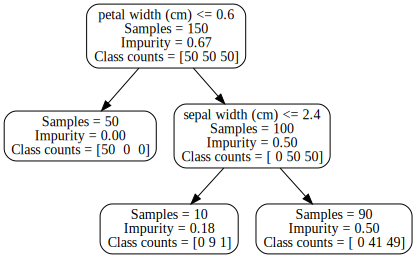

In [4]:
iris_sample_vals = iris_sample.values

# # for small sample
# X = iris_sample_vals[:,:-1]
# y = iris_sample_vals[:,-1]

X = iris_df.values[:,:-1]
y = iris_df.values[:,-1]

logger.setLevel(logging.INFO)

random_forest = RandomForest(n_classes=3, n_trees=3)
random_forest.fit(X, y)

feature_names = iris_data['feature_names']
random_forest.render(tree_id=0, feature_names=feature_names)

### Example prediction on Iris data set

In [5]:
random_forest.predict_proba(X[0:4,:])

array([[0.03875969, 0.77235142, 0.18888889],
       [0.70542636, 0.29457364, 0.        ],
       [0.        , 0.22457912, 0.77542088],
       [0.03875969, 0.77235142, 0.18888889]])

In [6]:
random_forest.predict(X)

array([1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0,
       0, 2, 1, 2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 1,
       1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 0, 1, 2])

In [7]:
y.astype(int)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1,
       1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

## TODO neural network regressor - Boston housing data

### Load Boston housing data

In [11]:
boston_data = load_boston()
boston_df = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston_df['y'] = boston_data['target']
boston_df = boston_df.sample(frac=1, random_state=42).reset_index(drop=True)
boston_sample = boston_df.head(5)
boston_sample

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.09178,0.0,4.05,0.0,0.510,6.416,84.1,2.6463,5.0,296.0,16.6,395.50,9.04,23.6
1,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,17.6,396.90,3.53,32.4
2,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,20.1,390.11,18.07,13.6
3,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,390.91,5.52,22.8
4,5.09017,0.0,18.10,0.0,0.713,6.297,91.8,2.3682,24.0,666.0,20.2,385.09,17.27,16.1


### Fit neural network on Boston data

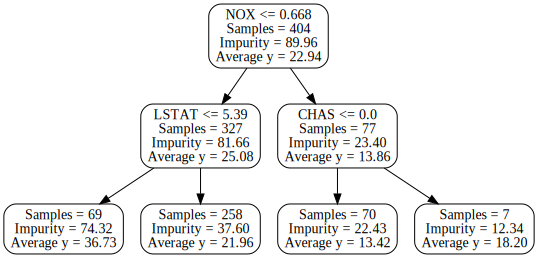

In [12]:
X = boston_df.values[:,:-1]
y = boston_df.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
boston_random_forest = RandomForest(
    impurity='mse',
    is_classifier=False,
    n_trees=100,
    max_depth=2)
boston_random_forest.fit(X_train, y_train)

boston_feature_names = boston_data['feature_names']
boston_random_forest.render(tree_id=0,feature_names=boston_feature_names)

### Random forest accuracy on Boston data

In [13]:
y_pred = boston_random_forest.predict(X_test)
test_acc = r2_score(y_test, y_pred)
print(f'Test accuracy (R2 score) = {test_acc:.2%}')

Test accuracy (R2 score) = 61.39%


## end